In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Feb 11 18:35:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:19:00.0 Off |                  Off |
| 39%   66C    P2             172W / 450W |  10515MiB / 24564MiB |     35%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.bottleneck_swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 32
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = None
hp.N = 256
hp.z_activation = F.tanh

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.2391357421875
encoder.convs 5.989013671875
encoder.linear 0.2501220703125
prior 0.0
latent 0.0
decoder 6.278697967529297
decoder.linear 0.2578125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train02.11-2/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 78176
-rw-rw-r-- 1 scpark scpark  1139336  2월 11 18:35 events.out.tfevents.1707643359.scpark-X299-WU8
-rw-rw-r-- 1 scpark scpark 39455188  2월 11 18:33 save_10000
-rw-rw-r-- 1 scpark scpark 39449324  2월 11 18:22 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


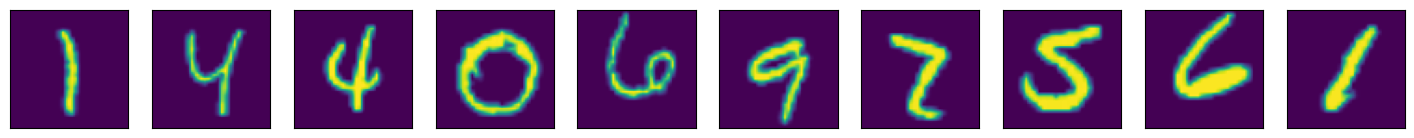

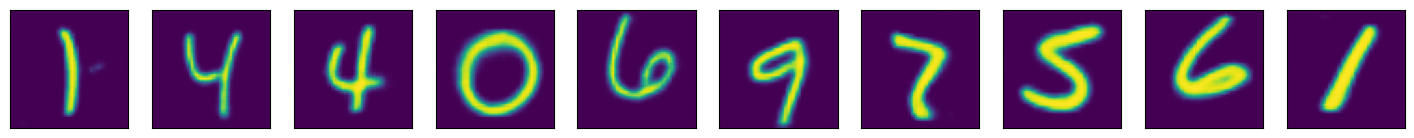

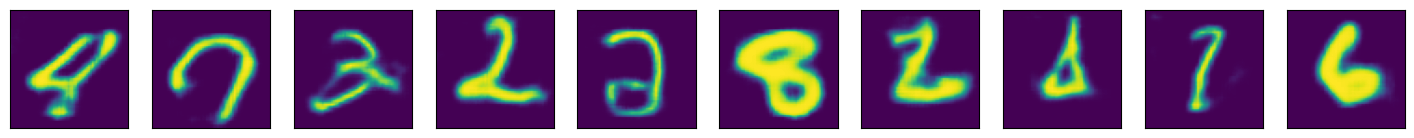

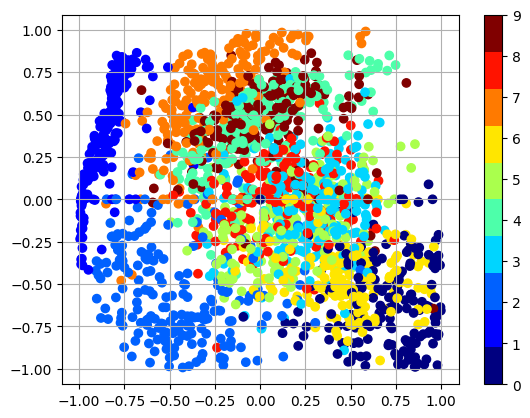

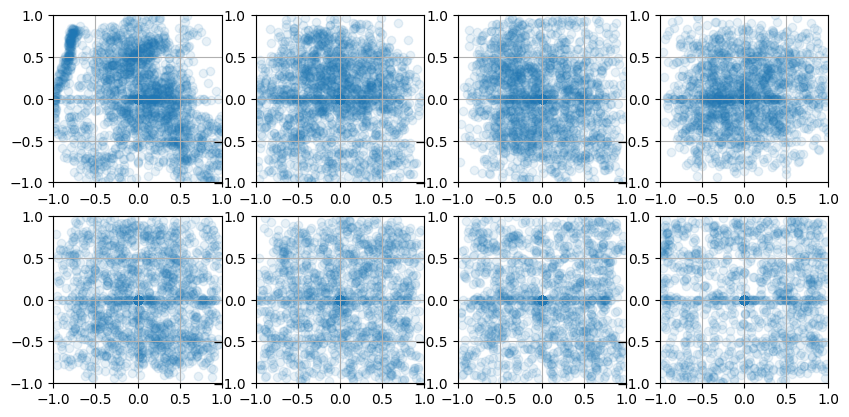

10001
swae_loss 0.007937179878354073
recon_loss 0.04330403357744217
10002
swae_loss 0.009034906513988972
recon_loss 0.0453474298119545
10003
swae_loss 0.006780312396585941
recon_loss 0.03844302520155907
10004
swae_loss 0.007032742258161306
recon_loss 0.04643189162015915
10005
swae_loss 0.007207826245576143
recon_loss 0.047871123999357224
10006
swae_loss 0.007392704486846924
recon_loss 0.04643227905035019
10007
swae_loss 0.009205939248204231
recon_loss 0.04479505866765976
10008
swae_loss 0.007801072206348181
recon_loss 0.05331677943468094
10009
swae_loss 0.008218315429985523
recon_loss 0.03987133502960205
10010
swae_loss 0.007669988553971052
recon_loss 0.04180104285478592
10011
swae_loss 0.009379920549690723
recon_loss 0.04498947411775589
10012
swae_loss 0.006787538528442383
recon_loss 0.046313852071762085
10013
swae_loss 0.007381312549114227
recon_loss 0.05203913152217865
10014
swae_loss 0.007701287046074867
recon_loss 0.04636205732822418
10015
swae_loss 0.00762292230501771
recon_loss 

swae_loss 0.008393163792788982
recon_loss 0.044153325259685516
10125
swae_loss 0.009668373502790928
recon_loss 0.048313893377780914
10126
swae_loss 0.007059975527226925
recon_loss 0.04362189769744873
10127
swae_loss 0.008027792908251286
recon_loss 0.04490538686513901
10128
swae_loss 0.006386013701558113
recon_loss 0.04572620242834091
10129
swae_loss 0.0075318654999136925
recon_loss 0.04393772408366203
10130
swae_loss 0.00791155081242323
recon_loss 0.04863397404551506
10131
swae_loss 0.007039294578135014
recon_loss 0.041170381009578705
10132
swae_loss 0.007624694146215916
recon_loss 0.03971899300813675
10133
swae_loss 0.007370836101472378
recon_loss 0.04255574569106102
10134
swae_loss 0.0071227834559977055
recon_loss 0.04799617454409599
10135
swae_loss 0.0066627999767661095
recon_loss 0.04667619988322258
10136
swae_loss 0.007209570147097111
recon_loss 0.04460363835096359
10137
swae_loss 0.008531931787729263
recon_loss 0.04937537759542465
10138
swae_loss 0.007015950512140989
recon_loss 0

swae_loss 0.007502620108425617
recon_loss 0.04913771152496338
10246
swae_loss 0.008795910514891148
recon_loss 0.048018671572208405
10247
swae_loss 0.009566638618707657
recon_loss 0.0370035395026207
10248



KeyboardInterrupt



In [10]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'wise_min_loss' in key:
                    loss = loss + data[key] * 1e+4
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = (torch.rand(10, hp.z_dim)*2-1).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
            
            _z = data['z'].data.cpu().numpy()

            plt.figure(figsize=[10, 10])
            for i in range(8):
                plt.subplot(4, 4, i+1)
                plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
                plt.grid()
                plt.xlim([-1, 1])
                plt.ylim([-1, 1])

            plt.show()
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')

In [ ]:
plt.figure(figsize=[10, 10])
for i in range(8):
    plt.subplot(4, 4, i+1)
    plt.scatter(_z[:, i*2], _z[:, i*2+1], alpha=0.1)
    plt.grid()
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
    
plt.show()